# MNE-practice: Motor Imagery Decoding

---

### from EEG data using the Common Spatial Pattern (CSP)

(motor imagery)EEGの`Common Spatial Pattern`BCI(Brain-Computer Interface)。


- [Reference/source](http://www.martinos.org/mne/stable/auto_examples/decoding/plot_decoding_csp_eeg.html#sphx-glr-auto-examples-decoding-plot-decoding-csp-eeg-py)


### Physionet Datasets

![](http://www.physionet.org/physiobank/database/eegmmidb/64_channel_sharbrough.png)

> The EEGs were recorded from 64 electrodes as per the international 10-10 system (excluding electrodes Nz, F9, F10, FT9, FT10, A1, A2, TP9, TP10, P9, and P10)

> **1.** A target appears on either the left or the right side of the screen. The subject **opens and closes the corresponding** fist until the target disappears. Then the subject relaxes.  


> **2.** A target appears on either the left or the right side of the screen. The subject **imagines opening and closing the corresponding fist** until the target disappears. Then the subject relaxes.  
  

> **3.** A target appears on either the top or the bottom of the screen. The subject **opens and closes either both fists (if the target is on top) or both feet (if the target is on the bottom)** until the target disappears. Then the subject relaxes.  

> **4.** A target appears on either the top or the bottom of the screen. The subject **imagines opening and closing either both fists (if the target is on top) or both feet (if the target is on the bottom)** until the target disappears. Then the subject relaxes.  


    - 1. Baseline, eyes open
    - 2. Baseline, eyes closed
    - 3. Task 1 (open and close left or right fist)
    - 4. Task 2 (imagine opening and closing left or right fist)
    - 5. Task 3 (open and close both fists or both feet)
    - 6. Task 4 (imagine opening and closing both fists or both feet)
    - 7. Task 1
    - 8. Task 2
    - 9. Task 3
    - 10. Task 4
    - 11. Task 1
    - 12. Task 2
    - 13. Task 3
    - 14. Task 4


In [1]:
# Authors: Martin Billinger <martin.billinger@tugraz.at>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)

Automatically created module for IPython interactive environment


#### 

In [3]:
# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1 # 
runs = [6, 10, 14]  # motor imagery: hands vs feet : task No.4 /

In [2]:
raw_fnames = eegbci.load_data(subject, runs)

raw_files = [read_raw_edf(f, preload=True, stim_channel='auto') for f in raw_fnames]

raw = concatenate_raws(raw_files) # concat: data matrix

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data
[.................................................] 100.00% (  2.5 MB,   1.2 MB/s) |   


Do you want to set the path:
    /Users/atsuya/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n?  n


Using default location ~/mne_data for EEGBCI...
[.................................................] 100.00% (  2.5 MB,   402 kB/s) \   


Do you want to set the path:
    /Users/atsuya/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n?  y


Attempting to create new mne-python configuration file:
/Users/atsuya/.mne/mne-python.json
[.................................................] 100.00% (  2.5 MB,   207 kB/s) \   
Extracting EDF parameters from /Users/atsuya/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/atsuya/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/atsuya/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf...
EDF file detected
EDF anno

#### 

In [4]:
# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

events = find_events(raw, shortest_event=0, stim_channel='STI 014')

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
89 events found
Event IDs: [1 2 3]
45 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped


Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Classification accuracy: 0.933333 / Chance level: 0.533333
Estimating covariance using EMPIRICAL
Done.
Estimating covari

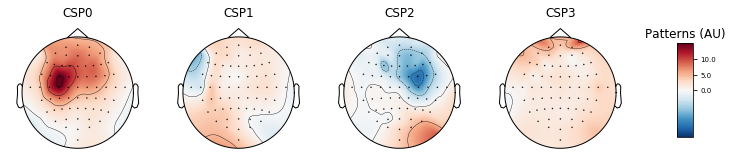

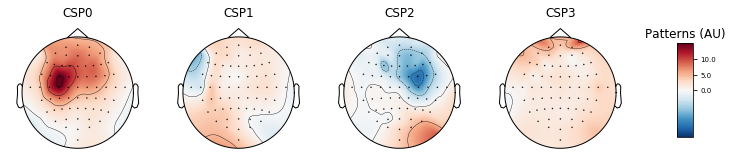

In [5]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

layout = read_layout('EEG1005')
csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Patterns (AU)', size=1.5)